In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
%load_ext zipline
import zipline

In [3]:
import talib
from zipline.api import order_target, record, symbol, order_target_percent

import pyfolio as pf
import pandas as pd

import os
os.chdir("/home/backstreet/use_zipline/rsi_strategy")


In [4]:
def initialize(context):
    stocklist = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
    
    context.stocks = [symbol(s) for s in stocklist]
    context.target_pct_per_stock = 1.0 / len(context.stocks)
    
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    
    
def handle_data(context, data):
    prices = data.history(context.stocks, 'price', bar_count=20, frequency="1d")
    rsis = {}
    
    for stock in context.stocks:
        rsi = talib.RSI(prices[stock], timeperiod=14)[-1]
        rsis[stock] = rsi
        
        current_position = context.portfolio.positions[stock].amount
        
        # RSI is above 70 and we own shares, time to sell
        if rsi > context.HIGH_RSI and current_position > 0 and data.can_trade(stock):
            order_target(stock, 0)
   
        # RSI is below 30 and we don't have any shares, time to buy
        elif rsi < context.LOW_RSI and current_position == 0 and data.can_trade(stock):
            order_target_percent(stock, context.target_pct_per_stock)
        
    # record the current RSI values of each stock for later ispection
    record(fb_rsi=rsis[symbol('FB')],
           amzn_rsi=rsis[symbol('AMZN')],
           aapl_rsi=rsis[symbol('AAPL')],
           nflx_rsi=rsis[symbol('NFLX')],
           googl_rsi=rsis[symbol('GOOGL')])
    


In [5]:
#%zipline --start 2014-1-1 --end 2018-1-1 -o perf.pickle --no-benchmark --capital-base 20000

In [6]:
def process_performance(fname):
    perf = pd.read_pickle('{}.pickle'.format(fname))
    perf.to_csv('{}.csv'.format(fname))
    # Normalize the dates
    perf.index = perf.index.normalize()
    return perf

def create_benchmark(fname):
    # benchmark_rets (pd.Series, optional) -- Daily noncumulative returns of the benchmark. This is in the same style as returns.
    bench = pd.read_csv('{}.csv'.format(fname), index_col='date', parse_dates=True, date_parser=lambda col: pd.to_datetime(col, utc=True))
    # Create a series
    bench_series = pd.Series(bench['return'].values, index=bench.index)
    bench_series.rename(fname, inplace=True)
    return bench_series

# Use PyFolio to generate a performance report - benchmark_rets is optional
def analyze(perfdata, benchdata):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perfdata)
    pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchdata)
    # pf.create_returns_tear_sheet(returns, benchmark_rets=benchdata)

In [7]:
perf = process_performance('perf')
perf

,aapl_rsi,algo_volatility,algorithm_period_return,alpha,amzn_rsi,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2014-01-02 00:00:00+00:00,42.909516,NaN,0.000000,None,58.118456,0.0,NaN,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,1,[],0.0
2014-01-03 00:00:00+00:00,35.692209,0.000000,0.000000,None,57.806443,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,2,[],0.0
2014-01-06 00:00:00+00:00,41.102738,0.000000,0.000000,None,53.652648,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,3,[],0.0
2014-01-07 00:00:00+00:00,35.982855,0.000000,0.000000,None,59.485819,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,4,[],0.0
2014-01-08 00:00:00+00:00,39.356867,0.000000,0.000000,None,60.865339,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,5,[],0.0
2014-01-09 00:00:00+00:00,37.699621,0.000000,0.000000,None,64.505961,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,6,[],0.0
2014-01-10 00:00:00+00:00,36.627536,0.000000,0.000000,None,61.050734,0.0,0.0,None,0.000000,20000.000000,...,0.0,0.0,0,NaN,20000.000000,0.000,0.000,7,[],0.0
2014-01-13 00:00:00+00:00,41.036816,0.000570,-0.000102,None,52.130758,0.0,0.0,None,-4043.752860,15956.247140,...,0.0,0.0,0,-5.612486,20000.000000,0.000,0.000,8,"[{'amount': 12, 'dt': 2014-01-13 21:00:00+00:0...",0.0
2014-01-14 00:00:00+00:00,47.113140,0.003757,0.000588,None,55.266512,0.0,0.0,None,0.000000,15956.247140,...,0.0,0.0,0,30.633332,15956.247140,4041.720,4041.720,9,[],0.0
2014-01-15 00:00:00+00:00,53.943069,0.023415,-0.003960,None,54.662790,0.0,0.0,None,0.000000,15956.247140,...,0.0,0.0,0,-4.368996,15956.247140,4055.520,4055.520,10,[],0.0


In [8]:
bench_series = create_benchmark('SPY')
bench_series

date
1993-02-01 00:00:00+00:00         NaN
1993-02-02 00:00:00+00:00    0.002119
1993-02-03 00:00:00+00:00    0.010570
1993-02-04 00:00:00+00:00    0.004184
1993-02-05 00:00:00+00:00   -0.000695
1993-02-08 00:00:00+00:00    0.000000
1993-02-09 00:00:00+00:00   -0.006949
1993-02-10 00:00:00+00:00    0.001399
1993-02-11 00:00:00+00:00    0.004892
1993-02-12 00:00:00+00:00   -0.007650
1993-02-16 00:00:00+00:00   -0.025228
1993-02-17 00:00:00+00:00   -0.000719
1993-02-18 00:00:00+00:00   -0.000720
1993-02-19 00:00:00+00:00    0.003600
1993-02-22 00:00:00+00:00    0.003588
1993-02-23 00:00:00+00:00   -0.000715
1993-02-24 00:00:00+00:00    0.012876
1993-02-25 00:00:00+00:00    0.002119
1993-02-26 00:00:00+00:00    0.001409
1993-03-01 00:00:00+00:00   -0.002816
1993-03-02 00:00:00+00:00    0.014821
1993-03-03 00:00:00+00:00    0.004172
1993-03-04 00:00:00+00:00   -0.005540
1993-03-05 00:00:00+00:00   -0.002785
1993-03-08 00:00:00+00:00    0.022346
1993-03-09 00:00:00+00:00   -0.003415
1993-03

In [9]:
bench_series = bench_series[bench_series.index.isin(perf.index)]
bench_series

date
2014-01-02 00:00:00+00:00   -0.009584
2014-01-03 00:00:00+00:00   -0.000164
2014-01-06 00:00:00+00:00   -0.002898
2014-01-07 00:00:00+00:00    0.006142
2014-01-08 00:00:00+00:00    0.000218
2014-01-09 00:00:00+00:00    0.000654
2014-01-10 00:00:00+00:00    0.002722
2014-01-13 00:00:00+00:00   -0.013305
2014-01-14 00:00:00+00:00    0.010898
2014-01-15 00:00:00+00:00    0.005390
2014-01-16 00:00:00+00:00   -0.001300
2014-01-17 00:00:00+00:00   -0.004229
2014-01-21 00:00:00+00:00    0.002941
2014-01-22 00:00:00+00:00    0.000651
2014-01-23 00:00:00+00:00   -0.008193
2014-01-24 00:00:00+00:00   -0.021336
2014-01-27 00:00:00+00:00   -0.004919
2014-01-28 00:00:00+00:00    0.005955
2014-01-29 00:00:00+00:00   -0.009605
2014-01-30 00:00:00+00:00    0.010601
2014-01-31 00:00:00+00:00   -0.005859
2014-02-03 00:00:00+00:00   -0.022505
2014-02-04 00:00:00+00:00    0.007004
2014-02-05 00:00:00+00:00   -0.001254
2014-02-06 00:00:00+00:00    0.013187
2014-02-07 00:00:00+00:00    0.012396
2014-02

Start date,2014-01-02
End date,2017-12-29
Total months,47
,Backtest
Annual return,12.8%
Cumulative returns,61.6%
Annual volatility,11.8%
Sharpe ratio,1.08
Calmar ratio,0.87
Stability,0.94
Max drawdown,-14.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.60,2014-02-18,2014-04-28,2015-02-03,251
1,10.24,2016-01-06,2016-02-08,2016-05-24,100
2,4.63,2015-07-20,2015-08-24,2015-08-27,29
3,3.98,2016-11-08,2016-11-14,2016-11-21,10
4,3.04,2016-05-31,2016-06-27,2016-06-30,23


Stress Events,mean,min,max
Apr14,-0.43%,-8.92%,2.13%
Oct14,-0.09%,-4.07%,1.29%
Fall2015,0.14%,-1.91%,3.34%
New Normal,0.05%,-8.92%,5.79%


Top 10 long positions of all time,max
sid,
FB,24.08%
NFLX,23.53%
AAPL,21.84%
AMZN,21.33%
GOOGL,20.16%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
FB,24.08%
NFLX,23.53%
AAPL,21.84%
AMZN,21.33%
GOOGL,20.16%


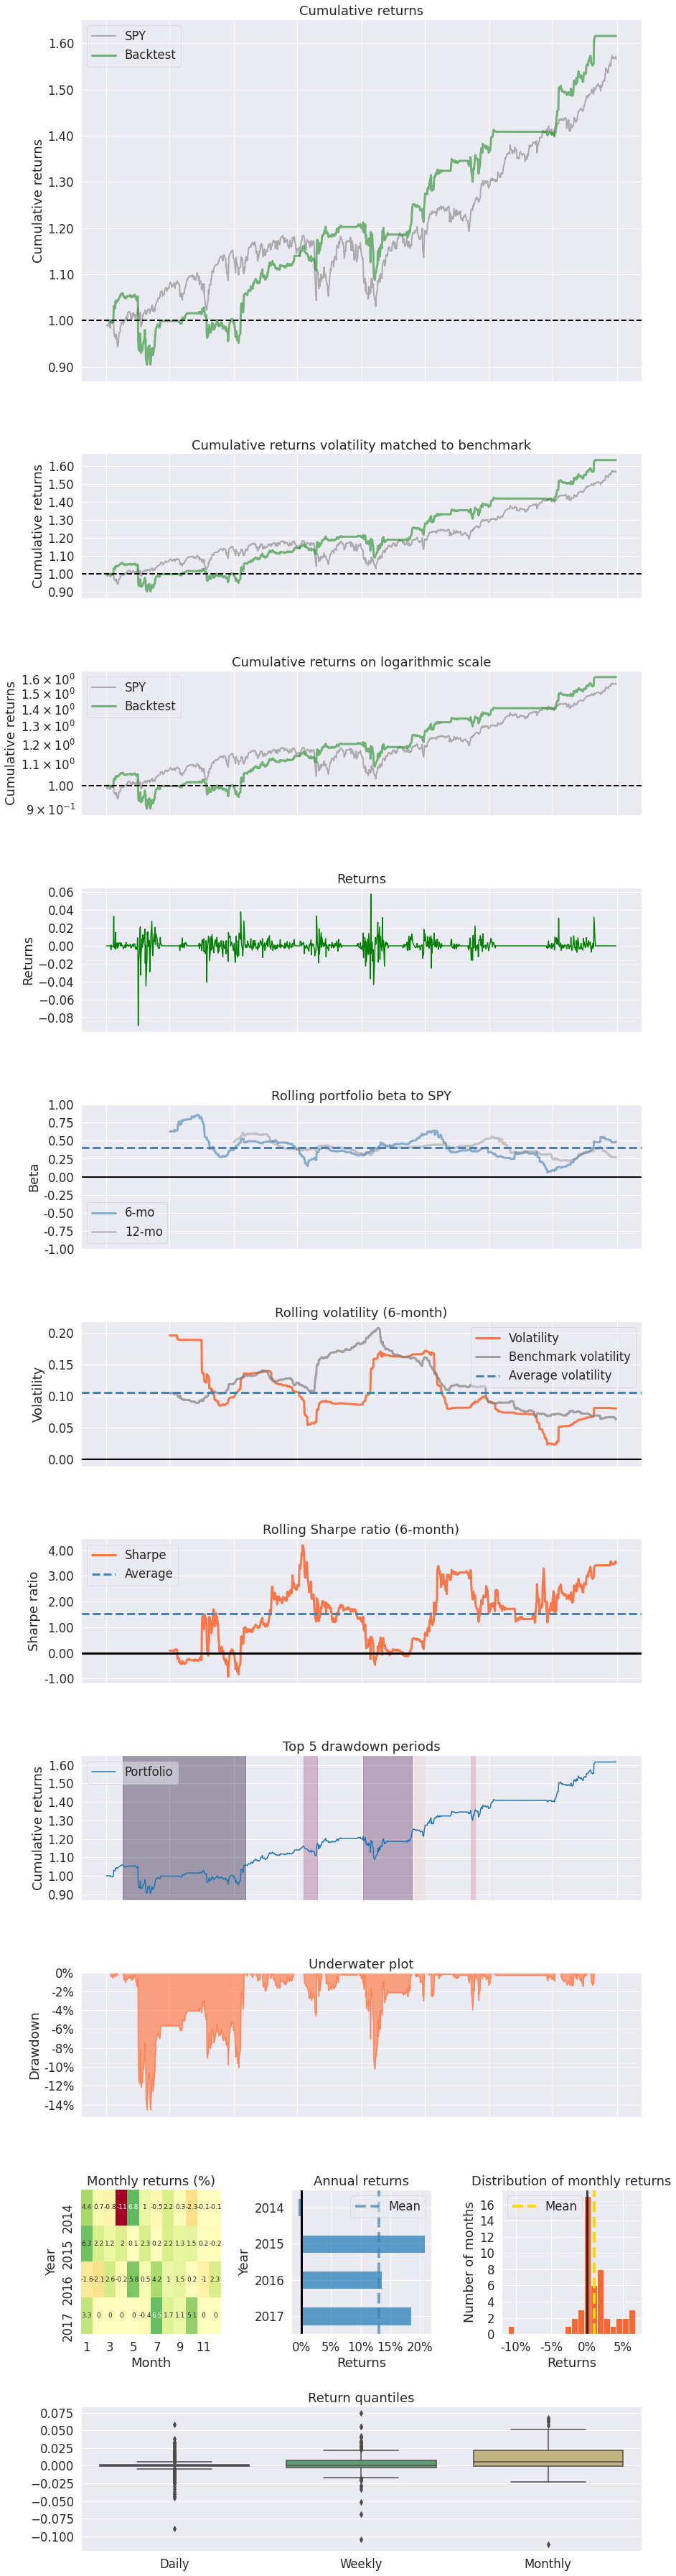

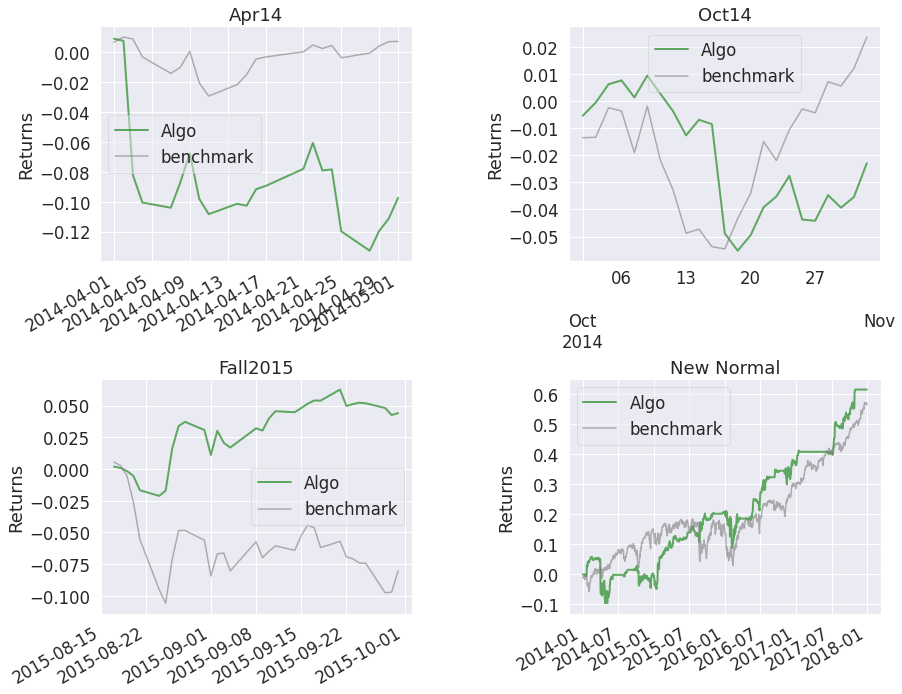

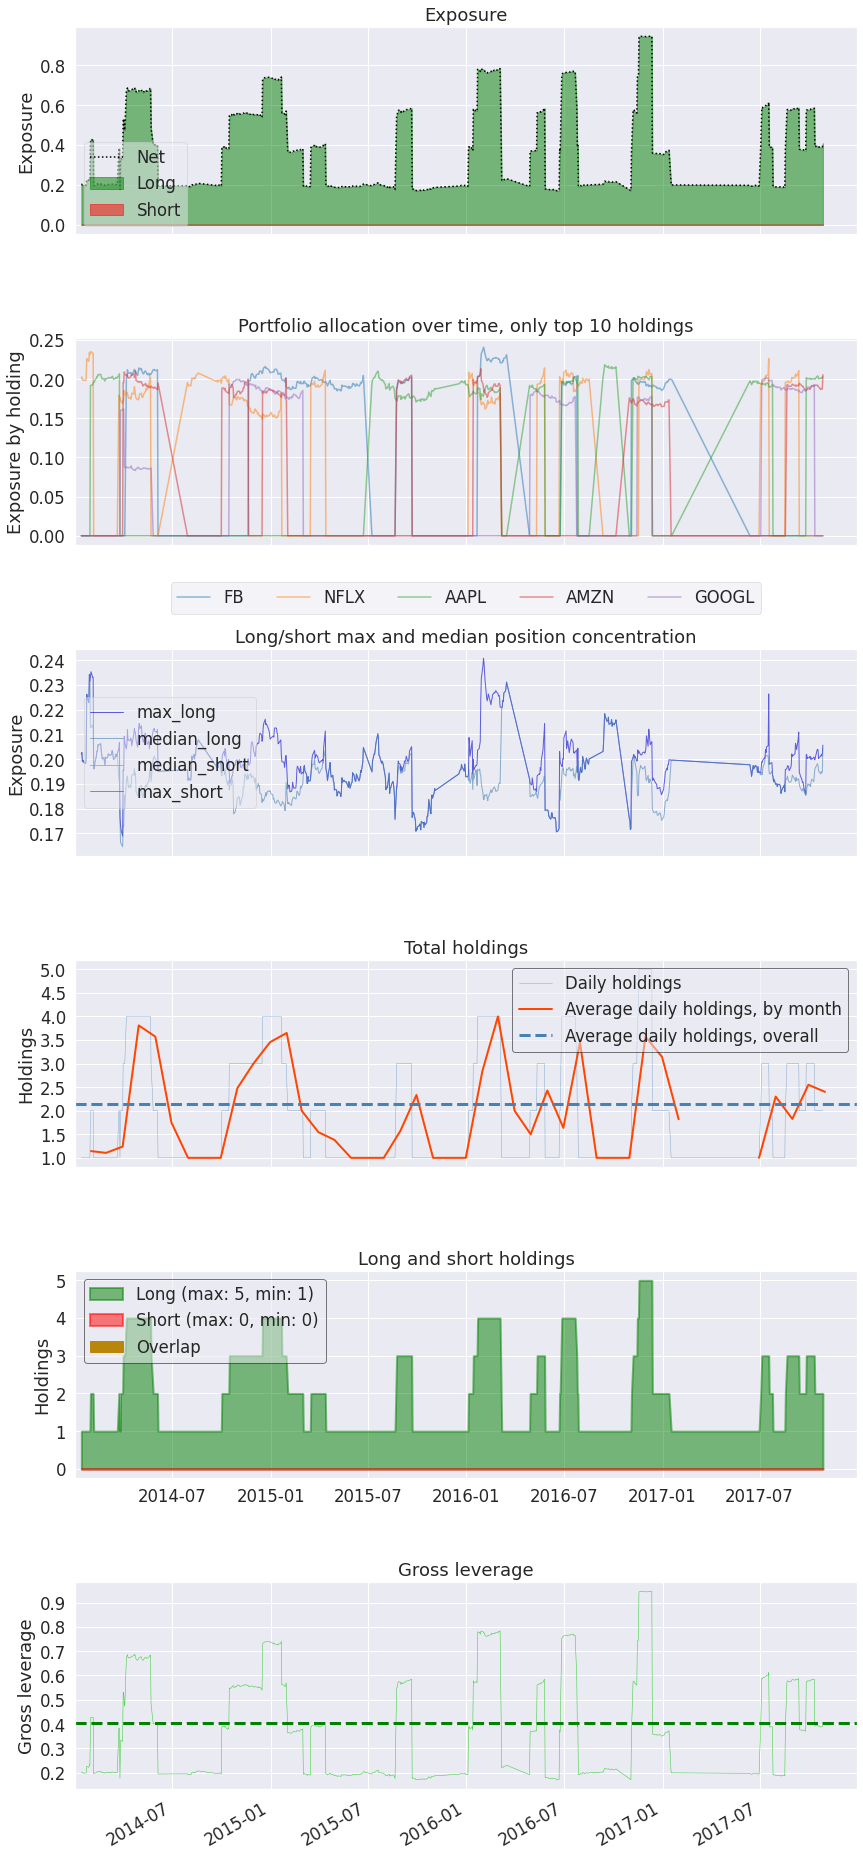

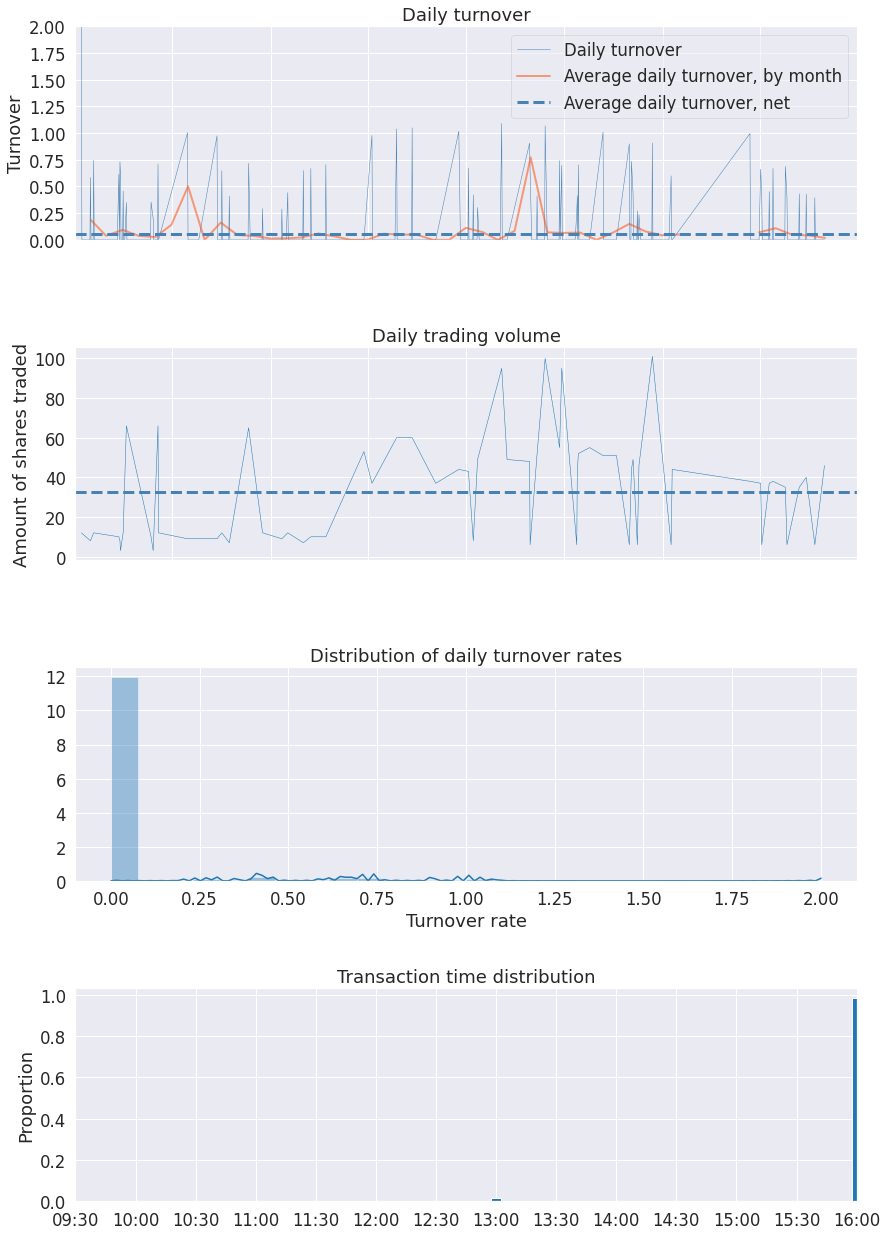

In [10]:
analyze(perf, bench_series)